# Show and Tell Lab : Neural Image Captioning
This lab is about creating a network which automatically generates captions of an image when given the image as an input, as in the original show and tell paper:

Paper : https://arxiv.org/pdf/1411.4555.pdf

References: 
https://www.tensorflow.org/tutorials/text/image_captioning


It consists of two parts: a CNN to detect objects in an image, and an LSTM to generate captions.

Dataset: 
Flickr30k

In [1]:
# UPLOAD YOUR KAGGLE.JSON FILE MANUALLY BY CLICKING ON FILES AND THEN UPLOAD
# or code wont execute


# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


## Download and Prep Flickr30k Dataset

In [3]:
# https://www.kaggle.com/general/51898
# this connects your kaggle acc to this notebook, copy pasted from above link
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
# download the dataset from kaggle directly
!kaggle datasets download -d hsankesara/flickr-image-dataset


kaggle.json
100% 8.15G/8.16G [03:08<00:00, 52.5MB/s]
100% 8.16G/8.16G [03:08<00:00, 46.4MB/s]


In [4]:
!unzip flickr-image-dataset.zip
!rm -rf flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [5]:
import pandas as pd
results_path = '/content/flickr30k_images/flickr30k_images/results.csv'
results_file = pd.read_csv(results_path, sep = '|', header = 0)
results_file.dropna(axis=0, how='any', inplace=True)
results_file.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


In [6]:
import collections
import numpy as np
from tqdm import tqdm
# this creates a dictionary which contains a list of captions for each image path
image_path_to_caption = collections.defaultdict(list)
for val in tqdm(np.unique(results_file['image_name'])):
    captions_all5 = results_file[results_file['image_name']==val][' comment']
    image_path = '/content/flickr30k_images/flickr30k_images/' + val
    for i in captions_all5:
        cap = "<start> " + i + " <end>"
        image_path_to_caption[image_path].append(cap)

100%|██████████| 31783/31783 [04:24<00:00, 119.97it/s]


In [7]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:8000]
print(len(train_image_paths))

train_captions = [] # contains captions
img_name_vector = [] # contains image paths (1 path per caption)

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

8000


<start>  A woman wearing a tan overcoat and black boots is walking down the street while carrying a white bag over her right shoulder . <end>


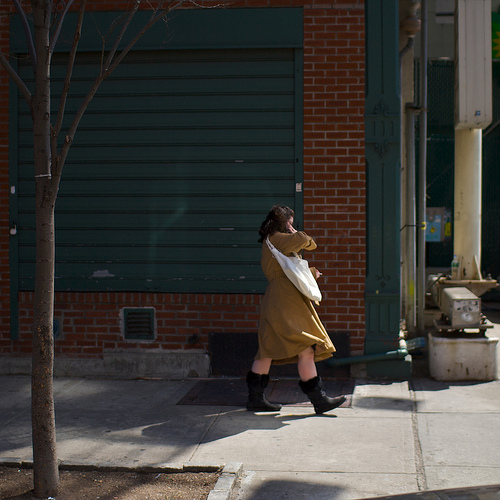

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess Images using Inception V3

In [9]:
# load image func
IMG_HEIGHT = 200
IMG_WIDTH = 200

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [10]:
# load pre-trained model
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [11]:
# Cache extracted features to disk

# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 500/500 [01:02<00:00,  8.03it/s]


## Preprocess and Tokenise Captions

In [12]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split data into training and test

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32000, 32000, 8000, 8000)

## Create a td.data dataset for training

In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

In [23]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

        

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [24]:
# EDITED FOR LSTM CELL
# changed lstm to gru for better result
# added dropout

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform', 
                                   dropout=0.1)
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)


  def call(self, x):
    x = self.embedding(x)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [25]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [27]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

In [29]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [30]:
# EDITED FOR LSTM 

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder(dec_input) #, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [31]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.6119
Epoch 1 Batch 100 Loss 0.9095
Epoch 1 Batch 200 Loss 0.9405
Epoch 1 Batch 300 Loss 0.8786
Epoch 1 Batch 400 Loss 0.9576
Epoch 1 Loss 0.879065
Time taken for 1 epoch 123.86734080314636 sec

Epoch 2 Batch 0 Loss 0.8276
Epoch 2 Batch 100 Loss 0.7924
Epoch 2 Batch 200 Loss 0.7670
Epoch 2 Batch 300 Loss 0.9023
Epoch 2 Batch 400 Loss 0.8401
Epoch 2 Loss 0.767190
Time taken for 1 epoch 74.51340246200562 sec

Epoch 3 Batch 0 Loss 0.7422
Epoch 3 Batch 100 Loss 0.7978
Epoch 3 Batch 200 Loss 0.7881
Epoch 3 Batch 300 Loss 0.7914
Epoch 3 Batch 400 Loss 0.7079
Epoch 3 Loss 0.741886
Time taken for 1 epoch 74.73000884056091 sec

Epoch 4 Batch 0 Loss 0.6940
Epoch 4 Batch 100 Loss 0.7004
Epoch 4 Batch 200 Loss 0.7445
Epoch 4 Batch 300 Loss 0.6521
Epoch 4 Batch 400 Loss 0.8108
Epoch 4 Loss 0.727512
Time taken for 1 epoch 73.04599809646606 sec

Epoch 5 Batch 0 Loss 0.7218
Epoch 5 Batch 100 Loss 0.6492
Epoch 5 Batch 200 Loss 0.7546
Epoch 5 Batch 300 Loss 0.7786
Epoch 5 Batch 400

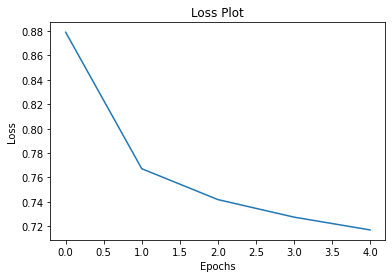

In [32]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Captions

In [33]:
# LSTM
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = decoder(dec_input)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)
    return result

In [34]:
# LSTM VERSION
def plot_attention(image, result):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(1, 1))
    plt.imshow(temp_image)
    plt.tight_layout()
    plt.show()

Real Caption: <start> a boy in a red and black shirt and black sandals kicks his foot back as he looks at the camera <end>
Prediction Caption: a men <end>


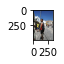

Real Caption: <start> a bunch of guys riding bikes <end>
Prediction Caption: a building <end>


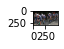

Real Caption: <start> a man beneath a red and white tent about to sit down <end>
Prediction Caption: a pins <end>


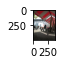

Real Caption: <start> dancers perform on stage <end>
Prediction Caption: two young male and crazy <end>


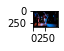

Real Caption: <start> a dirt biker coming around a turn on a track with the word <unk> in the background <end>
Prediction Caption: a little blond haired woman examines a back strolls down a large tongue <end>


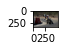

In [35]:
# LSTM VERSION
# captions on the validation set
for i in range(5):
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result = evaluate(image)

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', ' '.join(result))
  plot_attention(image, result)
